In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ('jaq', 1, 2) # animal, day, epoch

data = load_data(epoch_key)

12-Aug-20 08:49:43 Loading position information and linearizing...
12-Aug-20 08:51:28 Loading multiunits...


In [886]:
from replay_trajectory_classification import ClusterlessClassifier

cv_classifier = ClusterlessClassifier.load_model(f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier.pkl")
cv_classifier

ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                   ['uniform', 'uniform']],
                      model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=2.5, replay_speed=1)

In [887]:
import copy

import dask.bag as db
import networkx as nx
import numpy as np


def _distance_to_bin_centers(left_node, right_node, distance_left_node,
                             distance_right_node, time_ind, copy_graph,
                             place_bin_center_node_ids):
    node_name = f"actual_position_{time_ind}"
    copy_graph.add_node(node_name)
    copy_graph.add_edge(
        left_node, node_name, distance=distance_left_node)
    copy_graph.add_edge(
        node_name, right_node, distance=distance_right_node)
    distance_to_bin_centers = [
        nx.shortest_path_length(
            copy_graph, source=bin_center, target=node_name,
            weight="distance")
        for bin_center in place_bin_center_node_ids]
    copy_graph.remove_node(node_name)

    return distance_to_bin_centers


def find_adjacent_nodes(nodes_df, linear_position):
    # Find the index of the nodes to insert between
    right_bin_ind = np.searchsorted(
        nodes_df.linear_position.values, linear_position, side="right")
    left_bin_ind = right_bin_ind - 1

    # Fix for ones that fall into invalid track positions
    not_same_edge = (nodes_df.edge_id.values[left_bin_ind] !=
                     nodes_df.edge_id.values[right_bin_ind])
    right_bin_ind[not_same_edge] = right_bin_ind[not_same_edge] - 1
    left_bin_ind[not_same_edge] = left_bin_ind[not_same_edge] - 1

    # Get adjacent node names and distance
    left_node = nodes_df.reset_index().node_ids.values[left_bin_ind]
    right_node = nodes_df.reset_index().node_ids.values[right_bin_ind]

    distance_left_node = np.abs(
        nodes_df.loc[left_node].linear_position.values - linear_position)
    distance_right_node = np.abs(
        nodes_df.loc[right_node].linear_position.values - linear_position)

    return left_node, right_node, distance_left_node, distance_right_node


def get_distance_to_bin_centers(linear_position, decoder, npartitions=100):
    copy_graph = copy.deepcopy(decoder.track_graph_)
    linear_position = linear_position.squeeze()
    nodes_df = decoder._nodes_df.set_index("node_ids")
    place_bin_center_node_ids = (
        nodes_df
        .loc[~nodes_df.is_bin_edge]
        .reset_index()
        .node_ids
        .values)
    (left_node, right_node, distance_left_node,
     distance_right_node) = find_adjacent_nodes(nodes_df, linear_position)

    left_node = db.from_sequence(
        left_node, npartitions=npartitions)
    right_node = db.from_sequence(
        right_node, npartitions=npartitions)
    distance_left_node = db.from_sequence(
        distance_left_node, npartitions=npartitions)
    distance_right_node = db.from_sequence(
        distance_right_node, npartitions=npartitions)
    time_ind = db.from_sequence(
        range(linear_position.shape[0]), npartitions=npartitions)

    return np.asarray(left_node.map(
        _distance_to_bin_centers, right_node, distance_left_node,
        distance_right_node, time_ind, copy_graph,
        place_bin_center_node_ids).compute())


def gaussian_kernel(distance, bandwidth):
    return (np.exp(-0.5 * (distance / bandwidth)**2) /
            (bandwidth * np.sqrt(2.0 * np.pi))) / bandwidth


In [913]:
from scipy.stats import multivariate_normal

decoder = cv_classifier
position = data["position_info"].linear_position.values
position_bandwidth = 2.0

n_position_bins = decoder.place_bin_centers_[decoder.is_track_interior_].shape[0]
n_time = position.shape[0]
gaussian_pdf = gaussian_kernel(get_distance_to_bin_centers(position, decoder), position_bandwidth)

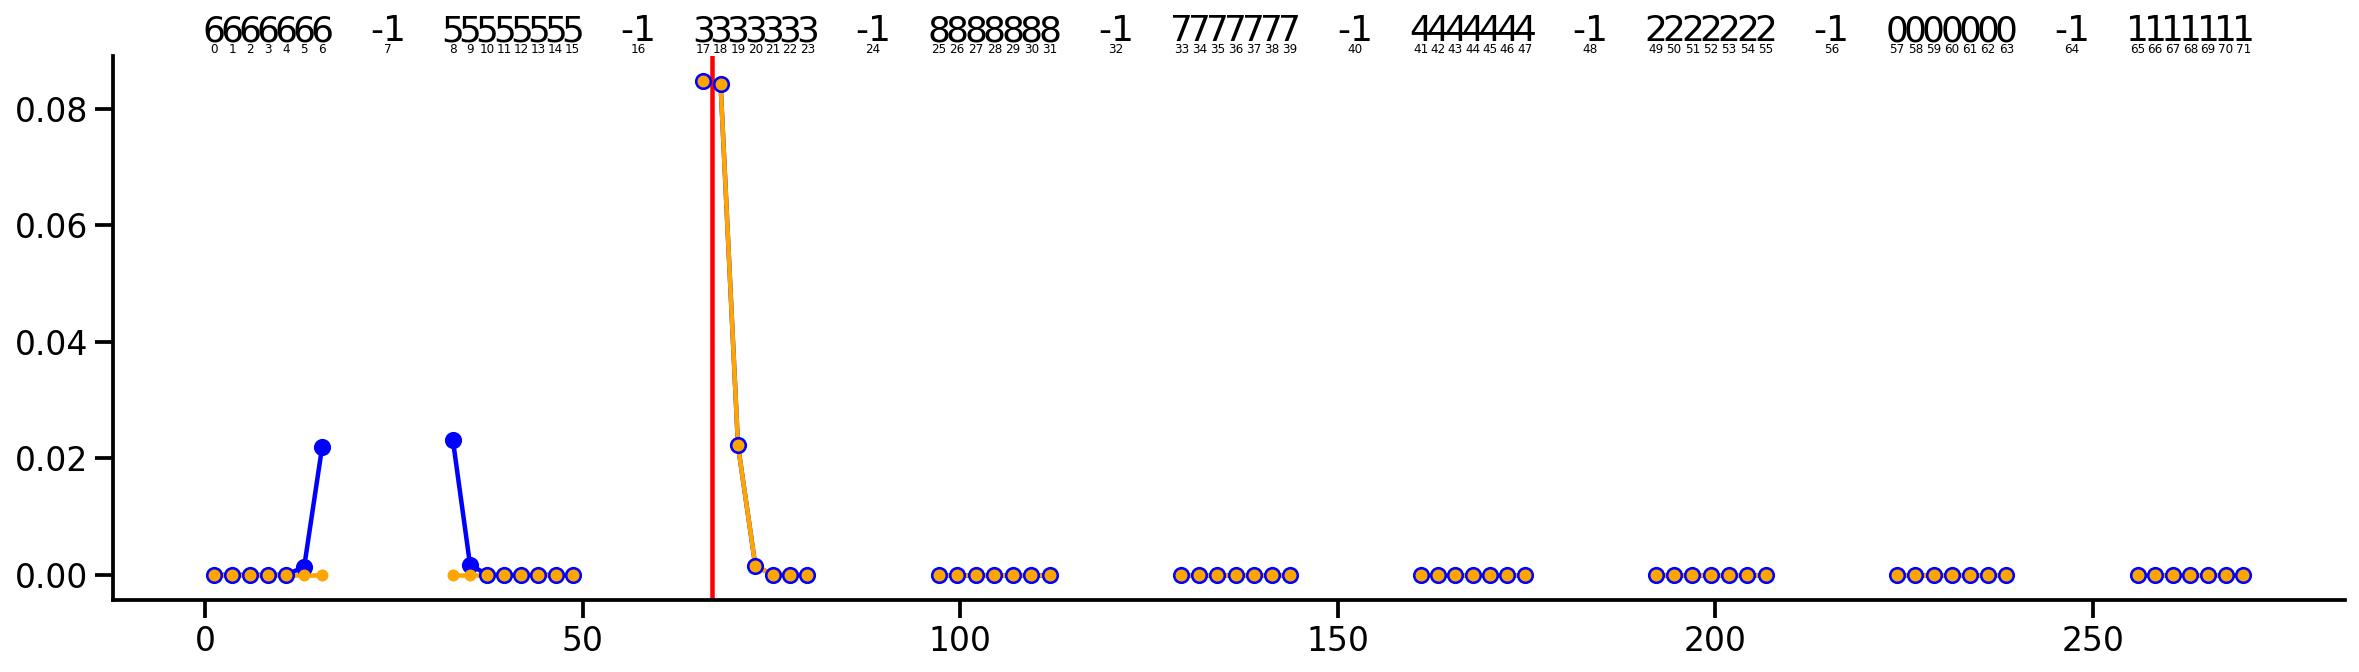

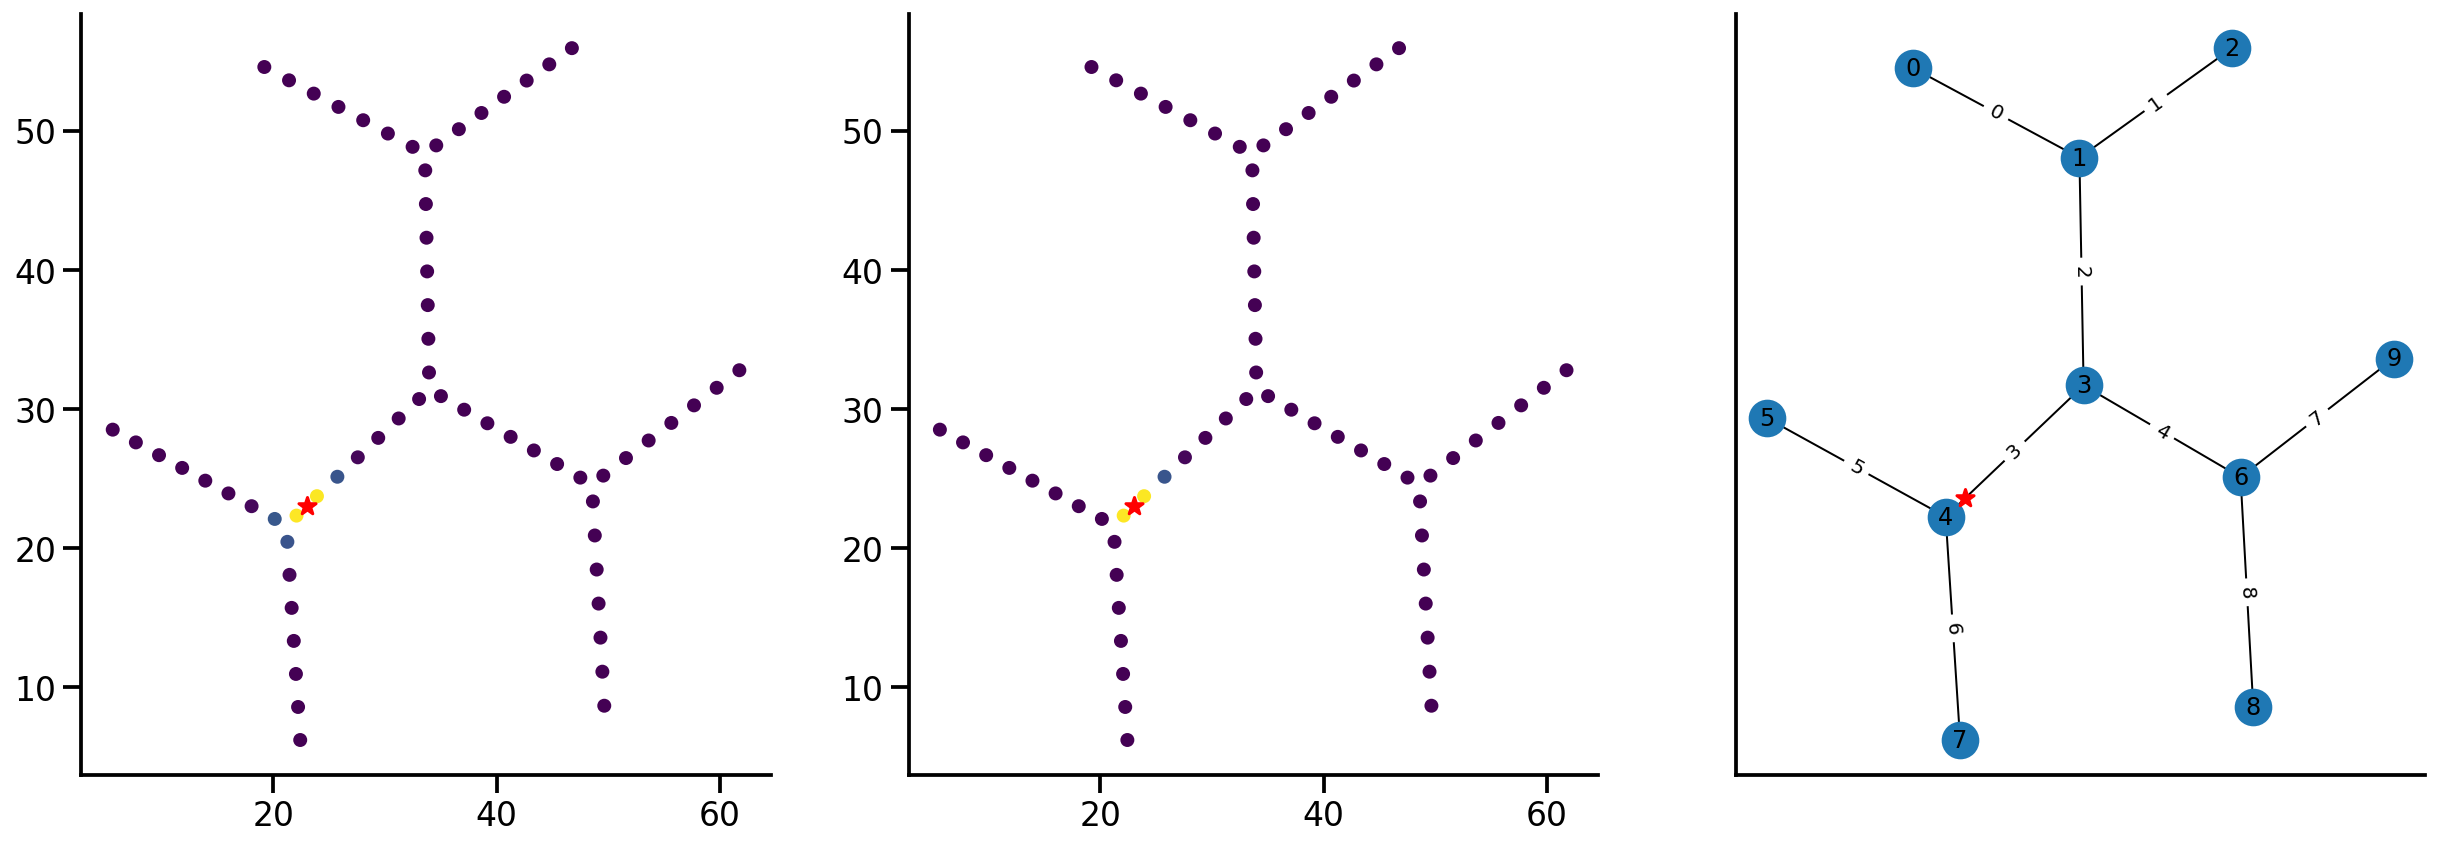

In [934]:
# 100, 150, 200

plt.figure(figsize=(20, 5))

time_ind = 34000

gaussian_pdf2 = gaussian_pdf[time_ind]
gaussian_pdf1 = gaussian_kernel(decoder.place_bin_centers_[decoder.is_track_interior_] - position[time_ind], position_bandwidth)
position_2D = data["position_info"].loc[:, ["projected_x_position", "projected_y_position"]].values[time_ind]

nodes_df = decoder._nodes_df.copy().loc[~decoder._nodes_df.is_bin_edge]
nodes_df["gaussian_pdf1"] = gaussian_pdf1
nodes_df["gaussian_pdf2"] = gaussian_pdf2

plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_pdf2, s=50, color="blue")
for _, df in nodes_df.groupby("edge_id"):
    plt.plot(df.linear_position, df.gaussian_pdf2, color="blue", zorder=-1)

plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_pdf1, s=20, color="orange")
for _, df in nodes_df.groupby("edge_id"):
    plt.plot(df.linear_position, df.gaussian_pdf1, color="orange", zorder=-1)
plt.axvline(position[time_ind], zorder=-1, color="red")
for center, edge_id in zip(decoder.place_bin_centers_, decoder.place_bin_center_ind_to_edge_id_):
    plt.text(center, gaussian_pdf2.max() * 1.1, edge_id, ha="center", va="center")
    
for center, edge_id in zip(decoder.place_bin_centers_, np.arange(decoder.place_bin_centers_.size)):
    plt.text(center, 1.05 * gaussian_pdf2.max(), edge_id, ha="center", va="bottom", fontsize=6)
sns.despine()

fig, axes = plt.subplots(1, 3, figsize=(21, 7))


axes[0].scatter(decoder.place_bin_center_2D_position_[decoder.is_track_interior_, 0],
                decoder.place_bin_center_2D_position_[decoder.is_track_interior_, 1],
                c=gaussian_pdf2,
                s=30, vmin=0.0, vmax=gaussian_pdf2.max())
axes[0].scatter(position_2D[0], position_2D[1], marker="*", color="red", zorder=100)

axes[1].scatter(decoder.place_bin_center_2D_position_[decoder.is_track_interior_, 0],
                decoder.place_bin_center_2D_position_[decoder.is_track_interior_, 1],
                c=gaussian_pdf1,
                s=30, vmin=0.0, vmax=gaussian_pdf2.max())
axes[1].scatter(position_2D[0], position_2D[1], marker="*", color="red", zorder=100)

track_graph = data["track_graph"]
node_position = nx.get_node_attributes(track_graph, 'pos')
nx.draw_networkx(track_graph, node_position, axes[2])
nx.draw_networkx_edge_labels(track_graph, node_position,
                             edge_labels={edge: ind for ind, edge in enumerate(track_graph.edges)})
sns.despine()
axes[2].scatter(position_2D[0], position_2D[1], marker="*", color="red", zorder=100)

(0.0, 0.05)

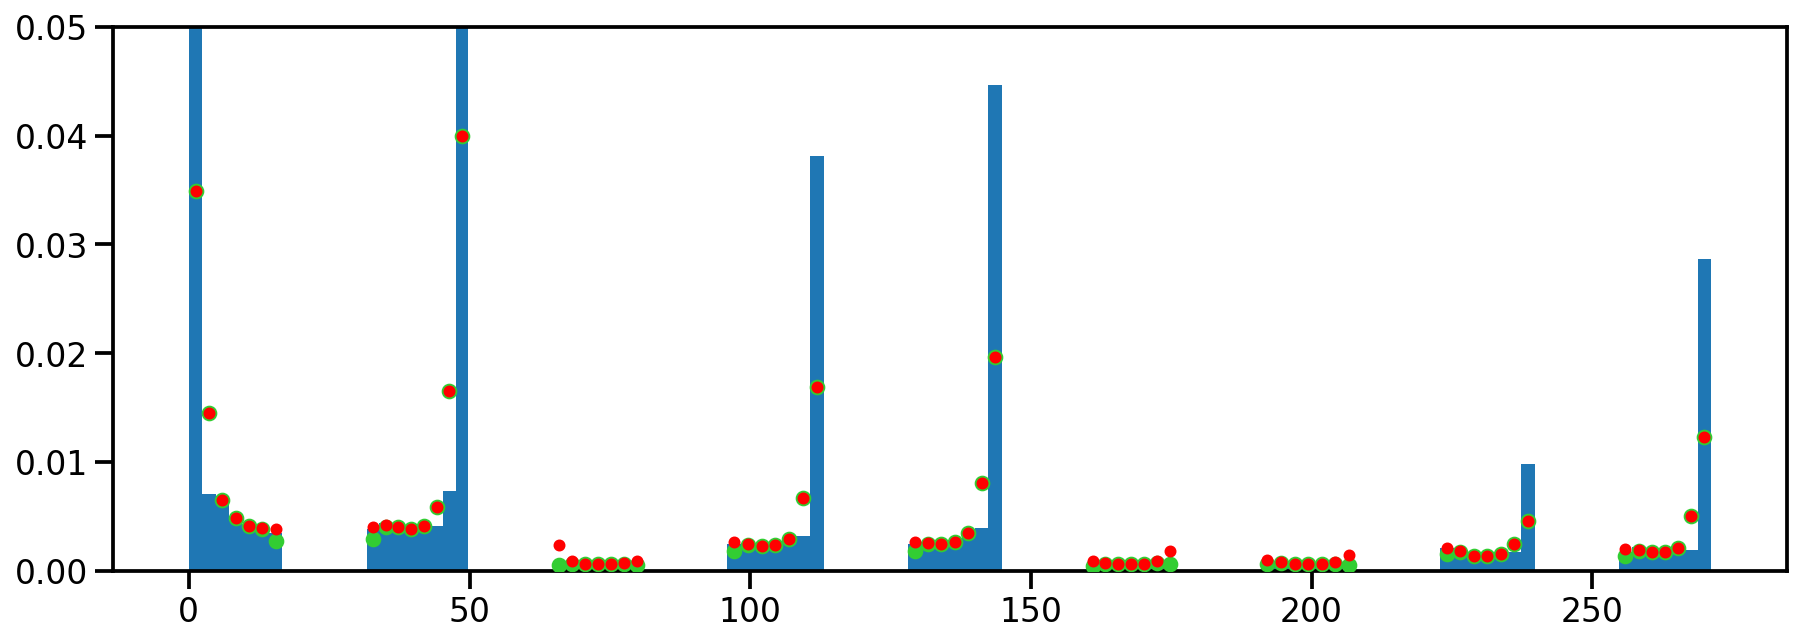

In [923]:
plt.figure(figsize=(15, 5))
plt.hist(position, density=True,
         bins=decoder.place_bin_edges_.squeeze());
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_pdf.mean(axis=0) * position_bandwidth,
            color="red", zorder=100, s=20)
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], 
            gaussian_kernel(decoder.place_bin_centers_[decoder.is_track_interior_].T -
                            position[:, np.newaxis], position_bandwidth).mean(axis=0) * position_bandwidth,
            color="limegreen", zorder=99, s=40)
plt.ylim((0.0, 0.05))

(0.0, 0.05)

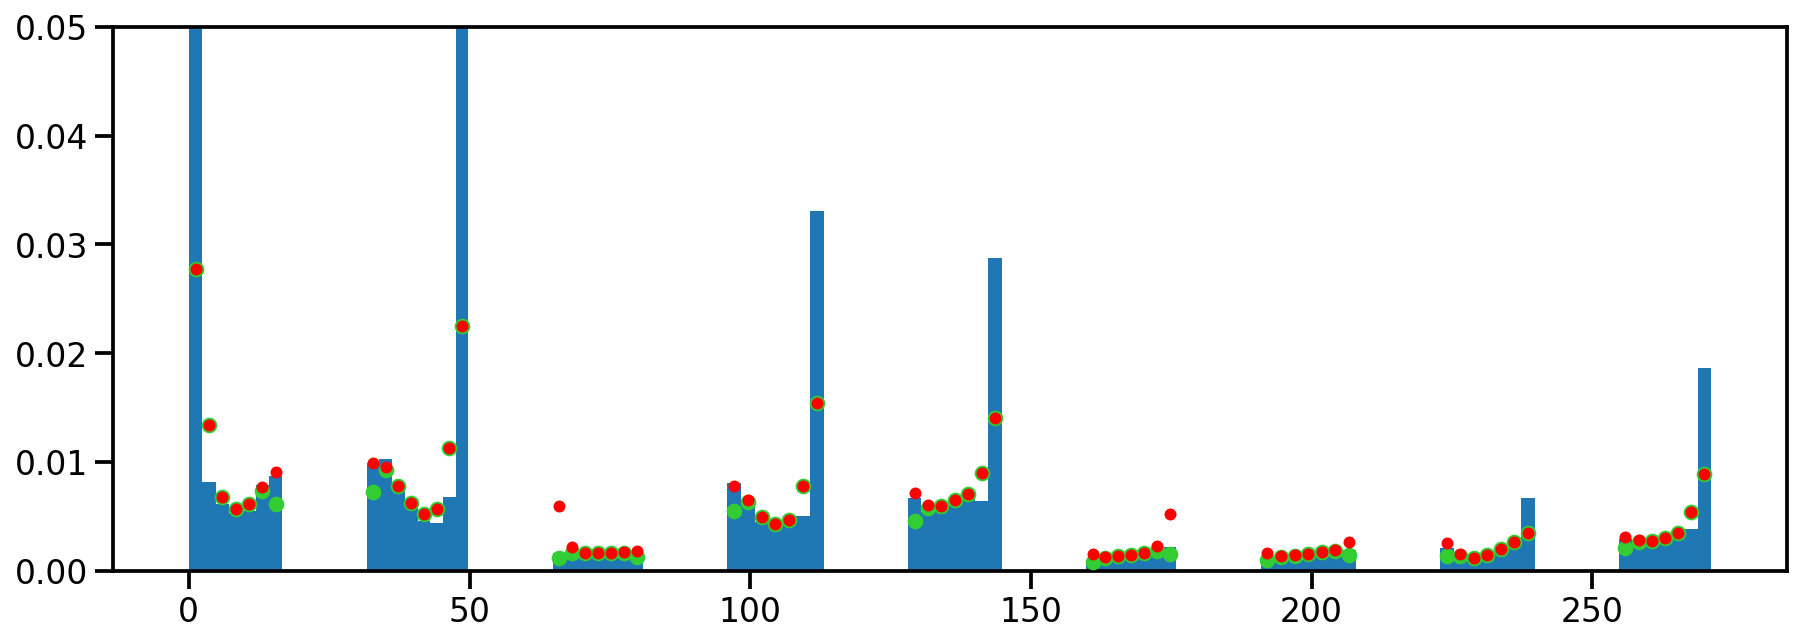

In [973]:
plt.figure(figsize=(15, 5))
is_spike = np.any(~np.isnan(data["multiunits"].isel(tetrodes=26).values), axis=1)

plt.hist(position[is_spike], density=True,
         bins=decoder.place_bin_edges_.squeeze());
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_pdf[is_spike].mean(axis=0) * position_bandwidth,
            color="red", zorder=100, s=20)
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], 
            gaussian_kernel(decoder.place_bin_centers_[decoder.is_track_interior_].T -
                            position[is_spike, np.newaxis], position_bandwidth).mean(axis=0) * position_bandwidth,
            color="limegreen", zorder=99, s=40)
plt.ylim((0.0, 0.05))

In [ ]:
time_ind = 200
linear_position = position
linear_position = linear_position.squeeze()
nodes_df = decoder._nodes_df.set_index("node_ids")
place_bin_center_node_ids = (
    nodes_df
    .loc[~nodes_df.is_bin_edge]
    .sort_values(by=['linear_position'])
    .reset_index()
    .node_ids
    .values)
(left_node, right_node, distance_left_node,
 distance_right_node) = find_adjacent_nodes(nodes_df, linear_position)

dbc = _distance_to_bin_centers(left_node[time_ind], right_node[time_ind], distance_left_node[time_ind],
                              distance_right_node[time_ind], decoder.track_graph_, place_bin_center_node_ids)
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_pdf1, s=50)
plt.scatter(decoder.place_bin_centers_[decoder.is_track_interior_], gaussian_kernel(np.asarray(dbc), position_bandwidth), s=20)


In [ ]:

dbc = [
    nx.shortest_path_length(
        copy_graph, source=node, target="actual_position",
        weight="distance")
    for node in place_bin_center_node_ids]

fig, ax = plt.subplots(figsize=(20, 20))
node_position = nx.get_node_attributes(copy_graph, 'pos')
nx.draw_networkx(copy_graph, node_position, ax)
plt.scatter(projected_xy[0, 0], projected_xy[0, 1], color="red", marker="*", zorder=100)
plt.scatter(decoder.place_bin_center_2D_position_[:, 0],
            decoder.place_bin_center_2D_position_[:, 1], zorder=99, s=1, color="orange")

In [466]:
distance_to_bin_centers2 = np.abs(decoder.place_bin_centers_[decoder.is_track_interior_].T -
                                position[train][is_running.iloc[train].values][:, np.newaxis])

distance_to_bin_centers[train][is_running.iloc[train].values][0, 52], distance_to_bin_centers2[0, 52]

(1.8102274995620613, 0.6007951473829394)

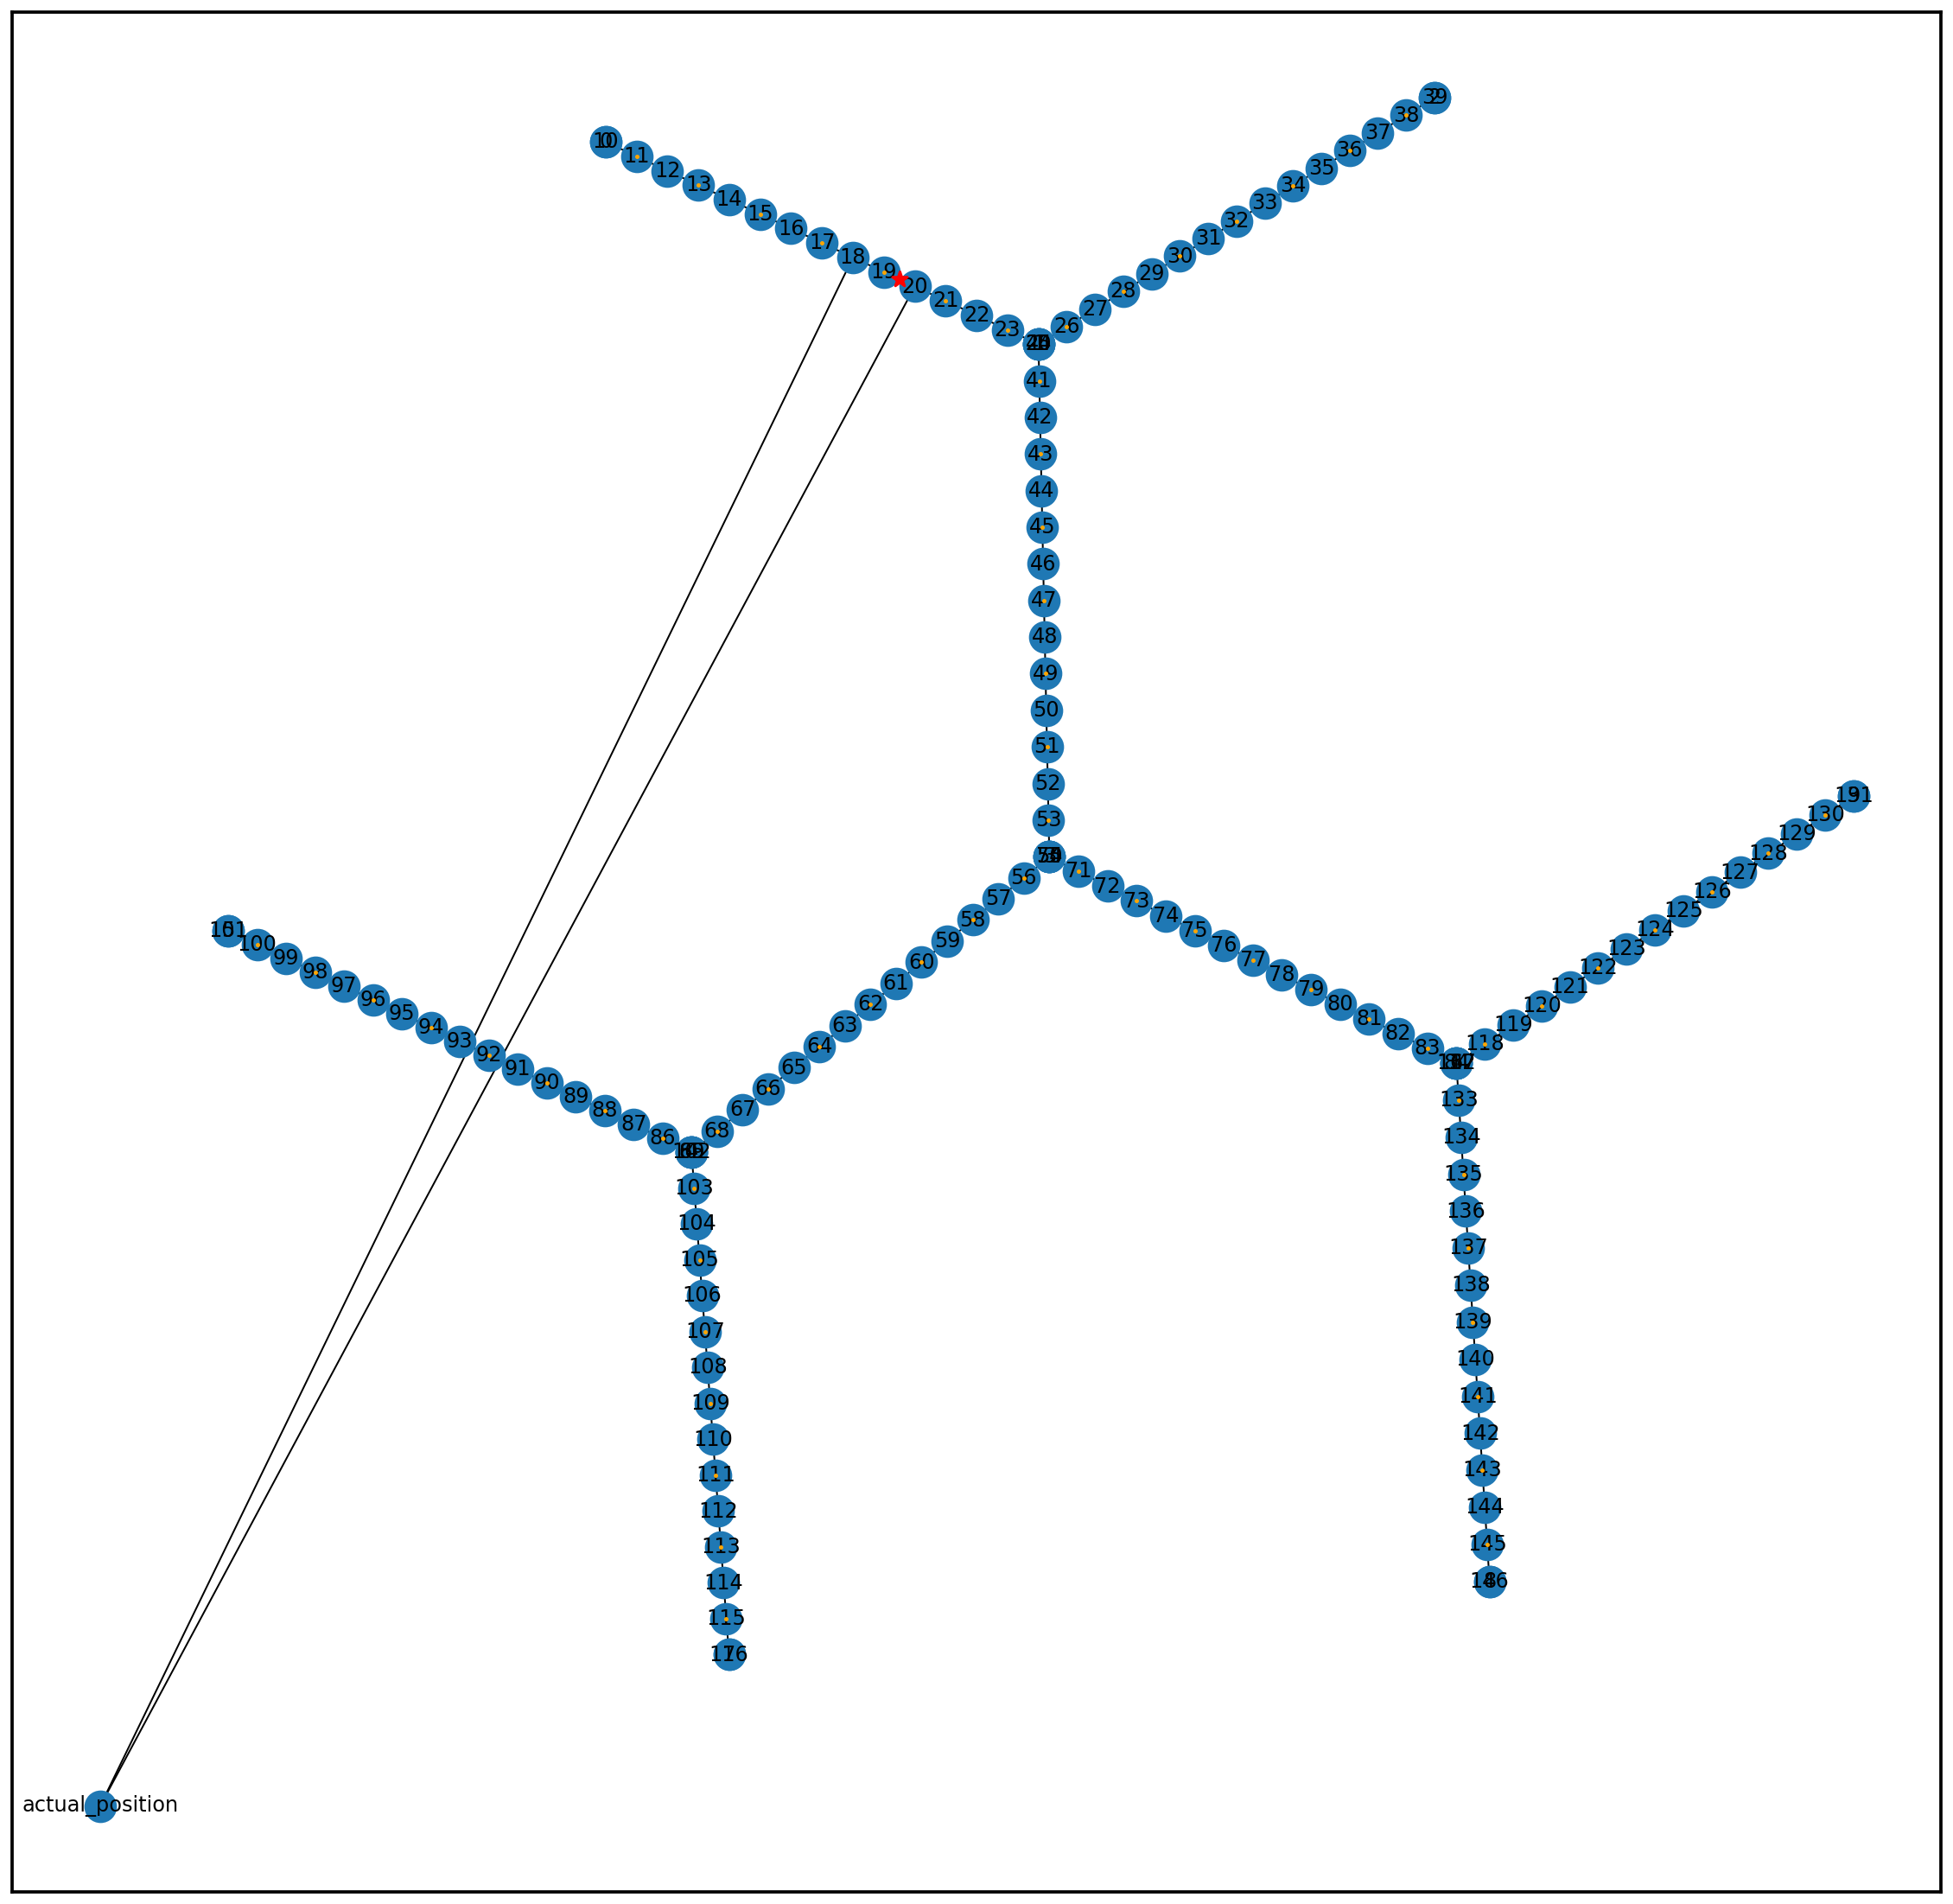

In [485]:
linear_position = data["position_info"].linear_position.values
projected_xy = data["position_info"].loc[:, ["projected_x_position", "projected_y_position"]].values

linear_position = linear_position.squeeze()
copy_graph = copy.copy(decoder.track_graph_)
nodes_df = decoder._nodes_df.set_index("node_ids")
place_bin_center_node_ids = (
    nodes_df
    .loc[~nodes_df.is_bin_edge]
    .sort_values(by=['linear_position'])
    .reset_index()
    .node_ids
    .values)
position_bin_center_node_id = _get_position_bin_center_node(linear_position, decoder)

node1, node2 = decoder.track_graph_[position_bin_center_node_id[0]]
copy_graph.add_node("actual_position", pos=(0, 0))
distance_node1 = np.abs(
    nodes_df.loc[node1].linear_position - linear_position[0])
distance_node2 = np.abs(
    nodes_df.loc[node2].linear_position - linear_position[0])
copy_graph.add_edge(
    node1, "actual_position", distance=distance_node1)
copy_graph.add_edge(
    node2, "actual_position", distance=distance_node2)
dbc = [
    nx.shortest_path_length(
        copy_graph, source=node, target="actual_position",
        weight="distance")
    for node in place_bin_center_node_ids]

fig, ax = plt.subplots(figsize=(20, 20))
node_position = nx.get_node_attributes(copy_graph, 'pos')
nx.draw_networkx(copy_graph, node_position, ax)
plt.scatter(projected_xy[0, 0], projected_xy[0, 1], color="red", marker="*", zorder=100)
plt.scatter(decoder.place_bin_center_2D_position_[:, 0],
            decoder.place_bin_center_2D_position_[:, 1], zorder=99, s=1, color="orange")

In [611]:
left_node_linear_position, right_node_linear_position

(array([227.69556923, 227.69556923, 227.69556923, ...,  48.67079234,
         48.67079234,  48.67079234]),
 array([228.90108055, 228.90108055, 228.90108055, ...,  49.80397747,
         49.80397747,  49.80397747]))

In [471]:
position_bin_center_node_id

array([ 19,  19,  19, ..., 100, 100, 100])

In [220]:
multiunits = data["multiunits"].values
is_spike = ((~np.isnan(multiunits)).sum(axis=(1, 2)) > 0)

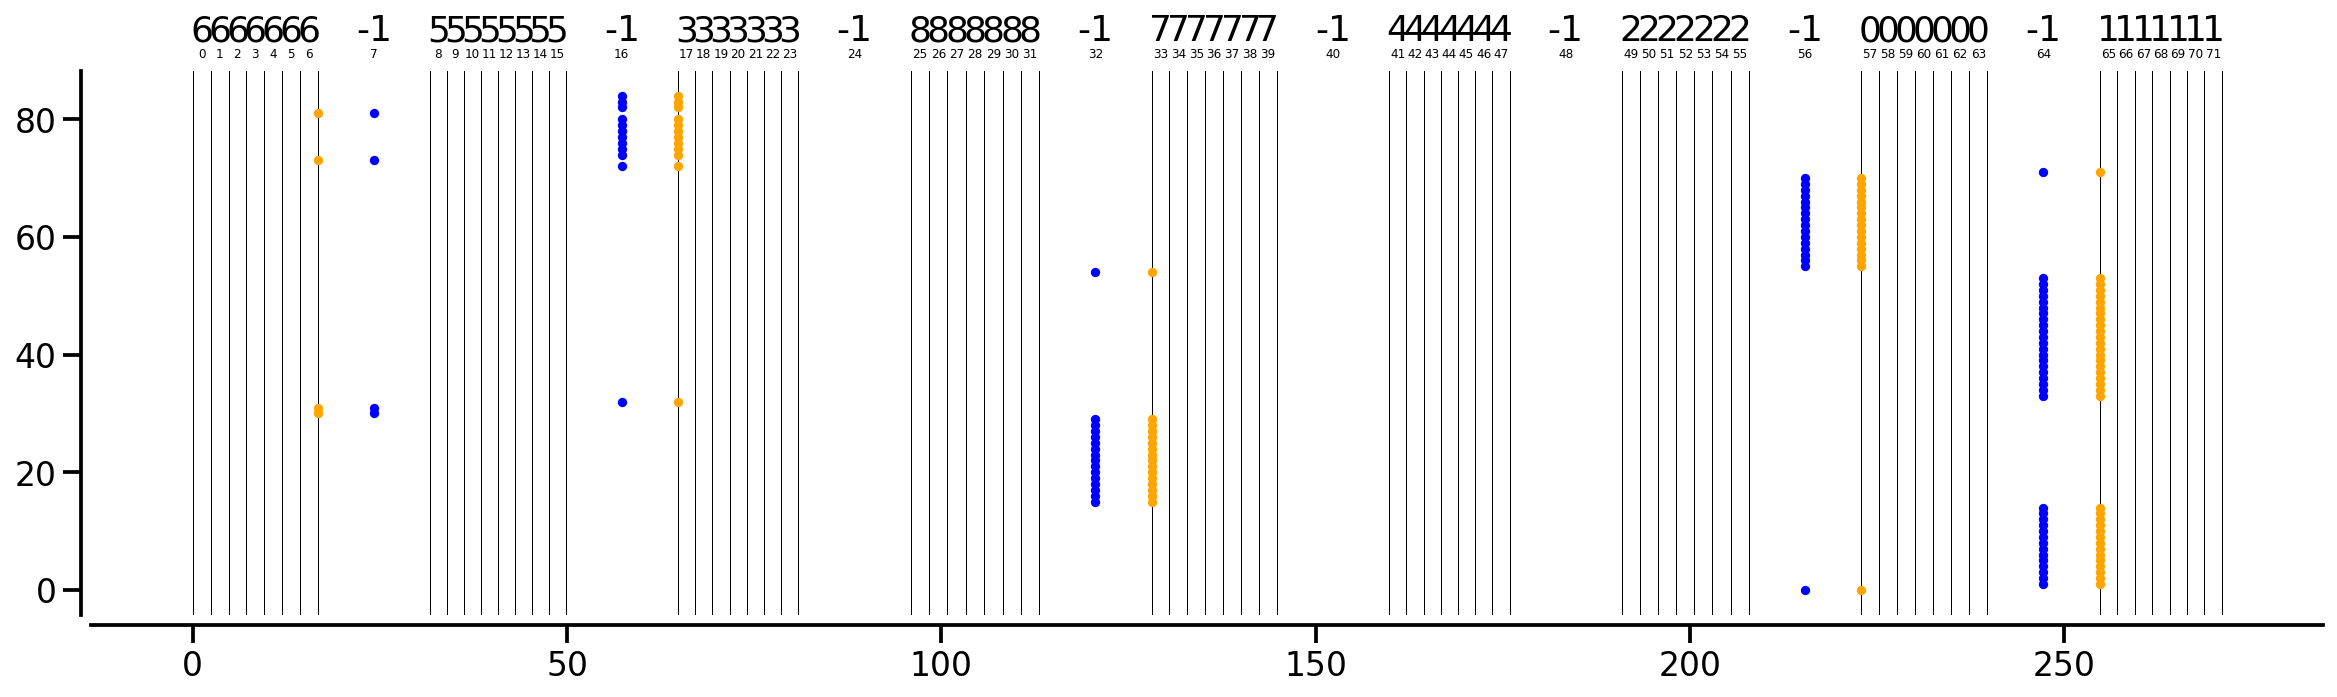

In [227]:
linear_position = data["position_info"].linear_position.values
track_segment_id = data["position_info"].track_segment_id.values

bin_ind = np.digitize(linear_position,
                      decoder.place_bin_edges_[1:-1].squeeze())

plt.figure(figsize=(20, 5))

for edge in decoder.place_bin_edges_:
    plt.axvline(edge, color="black", linewidth=0.5)

for center, edge_id in zip(decoder.place_bin_centers_, decoder.place_bin_center_ind_to_edge_id_):
    plt.text(center, 95, edge_id, ha="center", va="center")
    
for center, edge_id in zip(decoder.place_bin_centers_, np.arange(decoder.place_bin_centers_.size)):
    plt.text(center, 90, edge_id, ha="center", va="bottom", fontsize=6)
    
plt.scatter(linear_position[bad_bin_ind], range(len(bad_bin_ind)), s=10, zorder=100, color="orange")
plt.scatter(decoder.place_bin_centers_[bin_ind[bad_bin_ind]], range(len(bad_bin_ind)), s=10, zorder=100, color="blue")
sns.despine(offset=5)

In [228]:
decoder._nodes_df

,node_ids,edge_id,is_bin_edge,linear_position
0,7,6,True,0.000000
1,116,6,True,0.000000
2,115,6,False,1.190930
3,114,6,True,2.381859
4,113,6,False,3.572789
...,...,...,...,...
129,36,1,False,267.596400
133,37,1,True,268.764193
137,38,1,False,269.931985
143,39,1,True,271.099778


In [226]:
linear_position[bad_bin_ind[0]], bin_ind[bad_bin_ind[0]]

(222.8735239329709, 55)

[56 64 64 64 64 64 64 64 64 64 64 64 64 64 64 32 32 32 32 32 32 32 32 32
 32 32 32 32 32 32  7  7 16 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 32 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64
 16  7 16 16 16 16 16 16 16  7 16 16 16]
[57 65 65 65 65 65 65 65 65 65 65 65 65 65 65 33 33 33 33 33 33 33 33 33
 33 33 33 33 33 33  6  6 17 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65
 65 65 65 65 65 65 33 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 65
 17  6 17 17 17 17 17 17 17  6 17 17 17]


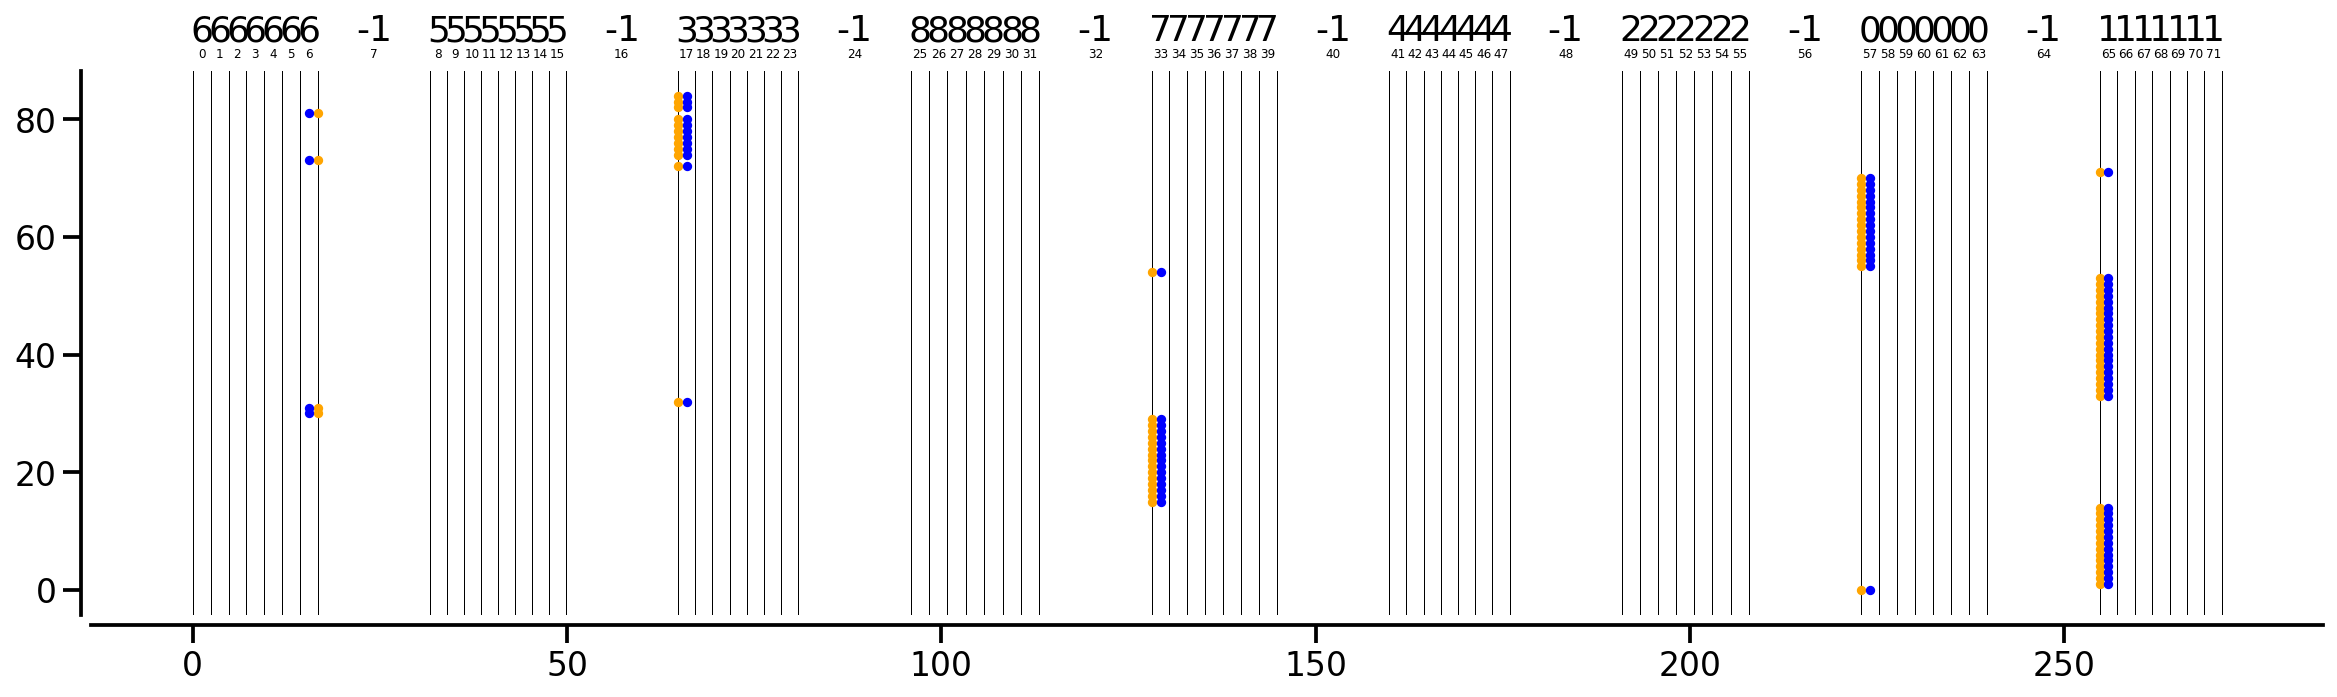

In [270]:
linear_position = data["position_info"].linear_position.values
track_segment_id = data["position_info"].track_segment_id.values

bin_ind = np.digitize(linear_position,
                      decoder.place_bin_edges_[1:-1].squeeze())
not_interior_bin_ind = np.nonzero(~decoder.is_track_interior_)[0]
bad_bin_ind = np.nonzero(np.isin(bin_ind, not_interior_bin_ind))[0]

print(bin_ind[bad_bin_ind])
is_odd = (bin_ind[bad_bin_ind] % 2).astype(bool)
bin_ind[bad_bin_ind[is_odd]] -= 1
bin_ind[bad_bin_ind[~is_odd]] += 1
print(bin_ind[bad_bin_ind])

plt.figure(figsize=(20, 5))

for edge in decoder.place_bin_edges_:
    plt.axvline(edge, color="black", linewidth=0.5)

for center, edge_id in zip(decoder.place_bin_centers_, decoder.place_bin_center_ind_to_edge_id_):
    plt.text(center, 95, edge_id, ha="center", va="center")
    
for center, edge_id in zip(decoder.place_bin_centers_, np.arange(decoder.place_bin_centers_.size)):
    plt.text(center, 90, edge_id, ha="center", va="bottom", fontsize=6)
    
plt.scatter(linear_position[bad_bin_ind], range(len(bad_bin_ind)), s=10, zorder=100, color="orange")
plt.scatter(decoder.place_bin_centers_[bin_ind[bad_bin_ind]], range(len(bad_bin_ind)), s=10, zorder=100, color="blue")
sns.despine(offset=5)

In [974]:
cv_classifier._nodes_df

,node_ids,edge_id,is_bin_edge,linear_position
0,7,6,True,0.000000
1,116,6,True,0.000000
2,115,6,False,1.190930
3,114,6,True,2.381859
4,113,6,False,3.572789
...,...,...,...,...
129,36,1,False,267.596400
133,37,1,True,268.764193
137,38,1,False,269.931985
143,39,1,True,271.099778
